In [273]:
# imports and global settings
import pandas as pd
import json
from constants import *
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as plt_ticker
from datetime import datetime
from collections import Counter, defaultdict
import squarify
from colour import Color

plt.rcParams['figure.figsize'] = [12, 8] # increase graphs size
plt.rcParams['figure.dpi'] = 100
plt.rc('font', size=10)

In [274]:
# draw dates on plot
dates = {
  # dropping Chaika since bitoin address started in 2016-12-08 - one year later
  # np.datetime64('2015-12-01'): 'Chaika', # 1 декабря 2015 Чайка
  np.datetime64('2017-03-02'): 'NeDimon', # 2 марта 2017 Он вам не Димон
  np.datetime64('2017-09-28'): 'V. Solovjov', # 28 сентября 2017 Квартиры, дача и итальянская вилла Владимира Соловьёва
  np.datetime64('2018-02-08'): 'Yachts & girls', # 8 февраля 2018 Яхты, олигархи, девочки
  np.datetime64('2018-03-06'): 'Forbidden palace', # 6 марта 2018 	Дворец, на который запрещено смотреть
  np.datetime64('2019-02-21'): 'Caucasus', # 21 февраля 2019 Как устроен Северный Кавказ
  np.datetime64('2019-11-11'): 'Life of a spy', # 11 ноября 2019 Тайная жизнь иностранного агента
  np.datetime64('2019-12-02'): 'Forbidden love', # 2 декабря 2019 Яхта. Самолёт. Девушка. Запретная любовь за ваш счёт
  np.datetime64('2020-01-28'): 'Mishustin', # 28 января 2020 Засекреченные миллиарды премьера Мишустина
  np.datetime64('2020-03-10'): 'Medvedev\'s island', # 10 марта 2020 Таинственный остров Медведева
  np.datetime64('2020-11-29'): 'Doctor', # 29 ноября 2020 Золотой дворец вашего любимого доктора
  np.datetime64('2020-12-14'): 'I know them', # 14 декабря 2020 Я знаю всех, кто пытался меня убить
  np.datetime64('2020-12-21'): 'Calling killer', # 21 декабря 2020 Я позвонил своему убийце. Он признался
  np.datetime64('2021-01-19'): 'Putin\'s palace', # 19 января 2021 Дворец для Путина
}

def _np_timedelta_to_days(td): # https://stackoverflow.com/questions/18215317
    days = td.astype('timedelta64[D]')
    return days / np.timedelta64(1, 'D')

def mark_dates(plt):
    prev = None
    y0, y1 = plt.ylim()
    y_delta = (y1-y0)/25
    y = ystart = y0 + 10*y_delta
    min_days_delta = 30
    for dt, name in dates.items():
        if prev and _np_timedelta_to_days(dt-prev) < min_days_delta:
            y += y_delta*4 
        else:
            y = ystart
        prev = dt
        plt.axvline(dt, linestyle = ':', c = 'b')
        plt.text(dt,y,name,rotation=90)


In [275]:
# btc to usd conversion
DAILY_PRICE_CSV = 'Bitstamp_BTCUSD_d.csv'

day_prices_df = pd.read_csv(DAILY_PRICE_CSV, header=1)
# unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
# 1612396800,2021-02-04 00:00:00,BTC/USD,37693.00,37941.90,37693.00,37909.33,186.87354753,7084250.981585455
day_prices_df = day_prices_df[['date','close']]
day_prices_df['date'] = day_prices_df['date'].apply(lambda dt: (dt.split(' ')[0]))
day_prices_df['date'] = day_prices_df['date'].apply(np.datetime64)
# filter out dates
day_prices_df = day_prices_df[day_prices_df['date'] > np.datetime64('2016-12-07')] 
day_prices_df = day_prices_df[day_prices_df['date'] < np.datetime64('2021-02-01')]

day_prices_df = day_prices_df.set_index('date')

def get_day(dt): # "2021-02-04 00:00:00" -> "2021-02-04"
    return dt.split(' ')[0]

def get_month(dt): # "2021-02-04 00:00:00" -> "2021-02"
    day = get_day(dt)
    return '-'.join(day.split('-')[:2])

def get_day_price(dt): # dt in '%Y-%M-%D %H:%M:%S' format
    day = dt.split(' ')[0]
    return day_prices_df.loc[day].close.values[0]

# test
print(get_day_price('2021-01-31'))

33141.38


In [276]:
# load transactions in dataframe
    
def get_our_output(transaction):
    return [output for output in transaction['outputs'] if output['address'] == ADDRESS][0]

# transfer fee return  
def enrich_transaction(transaction):
    mixer = False
    fee = None
    back = None
    if len(transaction['outputs']) > 3:
        mixer = True
    elif len(transaction['outputs']) == 3 or len(transaction['outputs']) == 2:
        our_output = get_our_output(transaction)
        transfer = our_output['btc']
        btcs = [output['btc'] for output in transaction['outputs'] if output != our_output]
        btcs = list(sorted(btcs))
        if btcs[0] < transfer:
            fee = btcs[0]
        if btcs[-1] > transfer:
            back = btcs[0]
    tmstmp = transaction['timestamp']
    return {
        'mixer': mixer,
        'fee': fee,
        'back': back,
        'back_addr': [output['address'] for output in transaction['outputs'] if output['btc'] == back][0] if back else None,
        'fee_usd': fee * get_day_price(tmstmp) if fee else fee,
        'back_usd': back * get_day_price(tmstmp) if back else back,
    }

def transaction_to_row(transaction):
    row = {}
    tmstmp = transaction['timestamp']
    dt = datetime.strptime(tmstmp, DATETIME_FORMAT)
    row['hour'] = dt.hour
    row['weekday'] = dt.weekday() + dt.hour/24.0 # to hours
    row['day'] = np.datetime64(get_day(tmstmp))
    #row['dt'] = dt
    row['month'] = np.datetime64(get_month(tmstmp)+'-15')
    row['btc'] = get_our_output(transaction)['btc']
    row['usd'] = row['btc'] * get_day_price(tmstmp)
    row.update(enrich_transaction(transaction))
    return row

transactions = [json.loads(line) for line in open('transactions.txt').readlines()]
# skip February 2021
transactions = [tr for tr in transactions if not tr['timestamp'].startswith('2021-02-')]

rows = list(map(transaction_to_row, transactions))
transactions_df = pd.DataFrame(rows)

print(transactions_df)

# get reused addresses
back_address_counts = Counter()
back_transfers = defaultdict(list)
back_address_total = Counter()

for i in range(len(transactions)):
    transaction = transactions[i]
    row = rows[i]
    if row['back_addr']:
        addr = row['back_addr']
        back_address_counts[addr] += 1
        back_transfers[addr].append((row['usd'], row['btc']))
        back_address_total[addr] = max(back_address_total[addr], row['usd'])



      hour   weekday        day      month       btc          usd  mixer  \
0       21  6.875000 2021-01-31 2021-01-15  0.102021  3381.116729  False   
1       21  6.875000 2021-01-31 2021-01-15  0.000608    20.161227  False   
2       21  6.875000 2021-01-31 2021-01-15  0.000354    11.743648  False   
3       20  6.833333 2021-01-31 2021-01-15  0.102500  3396.991450   True   
4       17  6.708333 2021-01-31 2021-01-15  0.008200   271.759316  False   
...    ...       ...        ...        ...       ...          ...    ...   
3626    11  1.458333 2016-12-13 2016-12-15  0.050000    38.935500  False   
3627    10  1.416667 2016-12-13 2016-12-15  0.030000    23.361300   True   
3628    10  1.416667 2016-12-13 2016-12-15  0.020000    15.574200   True   
3629     9  1.375000 2016-12-13 2016-12-15  0.050000    38.935500   True   
3630    16  3.666667 2016-12-08 2016-12-15  0.009600     7.372416   True   

           fee      back                           back_addr     fee_usd  \
0          

In [296]:
# check transactions
print('sanity check')
print('number of incoming transactions', len(transactions_df), 'check against blockchain.com: 3885(with added outcoming)')
print('received btc:', transactions_df['btc'].sum(), 'check against blockchain.com: 658')
print('total uds', transactions_df['usd'].sum())

sanity check
number of incoming transactions 3631 check against blockchain.com: 3885(with added outcoming)
received btc: 657.80852349 check against blockchain.com: 658
total uds 3613826.912113685


In [278]:
# back address repetitions
print(len(back_address_counts))
for addr, c in back_address_counts.most_common(10):
    print(c, addr, back_transfers[addr])

1492
23 1LoshagintUV9vze3o2kzF7Hyv9kq2ivo2 [(0.83756429, 0.000911), (0.7987101400000001, 0.000911), (0.75578382, 0.000911), (0.7533059, 0.000911), (0.71860591, 0.000911), (0.70720019, 0.000911), (0.70720019, 0.000911), (0.70720019, 0.000911), (0.70720019, 0.000911), (0.70720019, 0.000911), (0.70720019, 0.000911), (0.70720019, 0.000911), (0.70720019, 0.000911), (0.70720019, 0.000911), (0.70720019, 0.000911), (7.0720019, 0.00911), (0.70720019, 0.000911), (7.0720019, 0.00911), (7.0720019, 0.00911), (7.0720019, 0.00911), (7.0720019, 0.00911), (7.0720019, 0.00911), (7.0940481, 0.00911)]
21 1PutinHuj28G1Bc1WvFb9WxEKAKUDPUNEg [(4.8134451984, 0.00066666), (4.8641113584, 0.00066666), (4.792152078, 0.00066666), (0.48295123200000006, 6.66e-05), (0.48295123200000006, 6.66e-05), (0.48574542060000003, 6.666e-05), (0.48574542060000003, 6.666e-05), (0.48574542060000003, 6.666e-05), (4.8578914206, 0.00066666), (7.4858400000000005, 0.000666), (7.4858400000000005, 0.000666), (7.4858400000000005, 0.000666

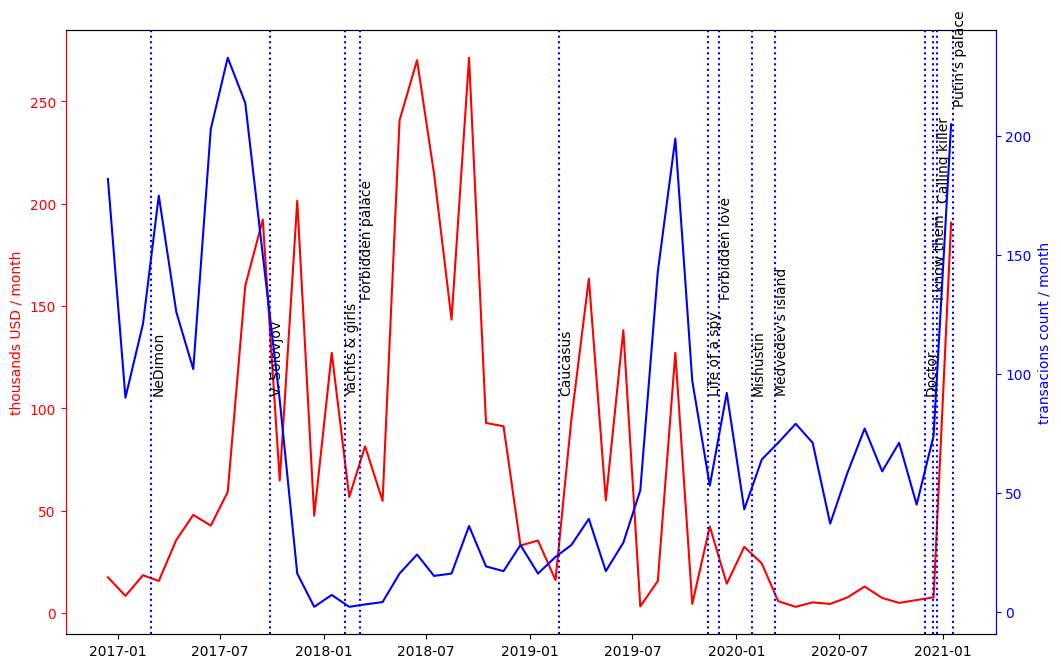

In [279]:
month_usd_sum = transactions_df.groupby('month').usd.agg(['sum'])

fig, ax = plt.subplots()
plt.plot(month_usd_sum, c= 'r')
mark_dates(plt)
ax.get_yaxis().set_major_formatter(
    plt_ticker.FuncFormatter(lambda x, p: format(int(x/1000), ','))
)
plt.ylabel('thousands USD / month')
ax.tick_params(axis='y', colors='red')
ax.yaxis.label.set_color('red')

month_count = transactions_df.groupby('month').usd.agg(['count'])
ax2 = ax.twinx()
ax2.plot(month_count, c= 'b')
ax2.set_ylabel('transacions count / month')
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')

ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('b')

plt.savefig('usd_and_transaction_count_month.png',bbox_inches='tight')
plt.show()

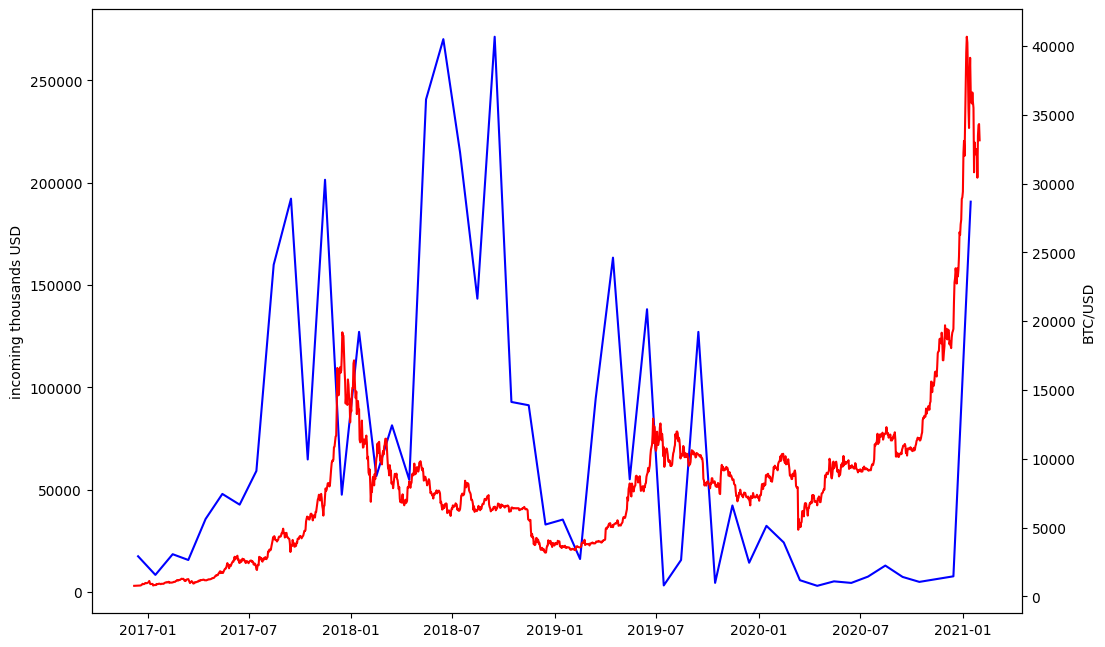

In [280]:
# usd per month against bitcoin price
month_usd_sum = transactions_df.groupby('month').usd.agg(['sum'])
fig, ax = plt.subplots()
ax.plot(month_usd_sum, c= 'b')
ax.set_ylabel('incoming thousands USD')

ax2 = ax.twinx()
ax2.plot(day_prices_df, c= 'r')
ax2.set_ylabel('BTC/USD')

plt.show()

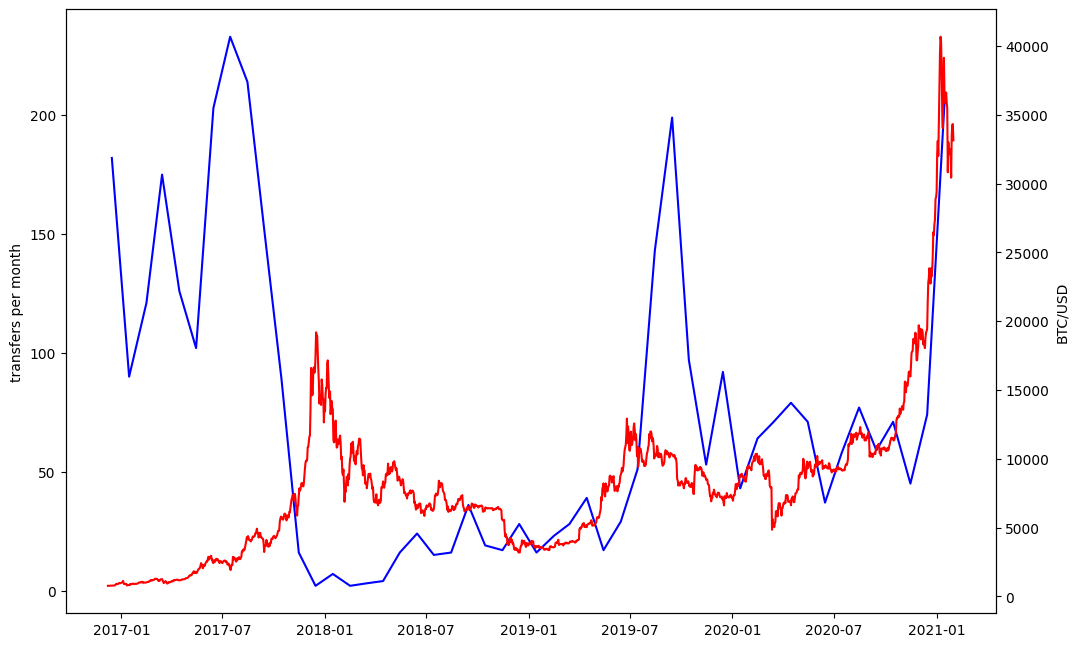

In [281]:
# transfers per month against bitcoin price
month_usd_sum = transactions_df.groupby('month').usd.agg(['sum'])
fig, ax = plt.subplots()
ax.plot(month_count, c= 'b')
ax.set_ylabel('transfers per month')

ax2 = ax.twinx()
ax2.plot(day_prices_df, c= 'r')
ax2.set_ylabel('BTC/USD')

plt.show()

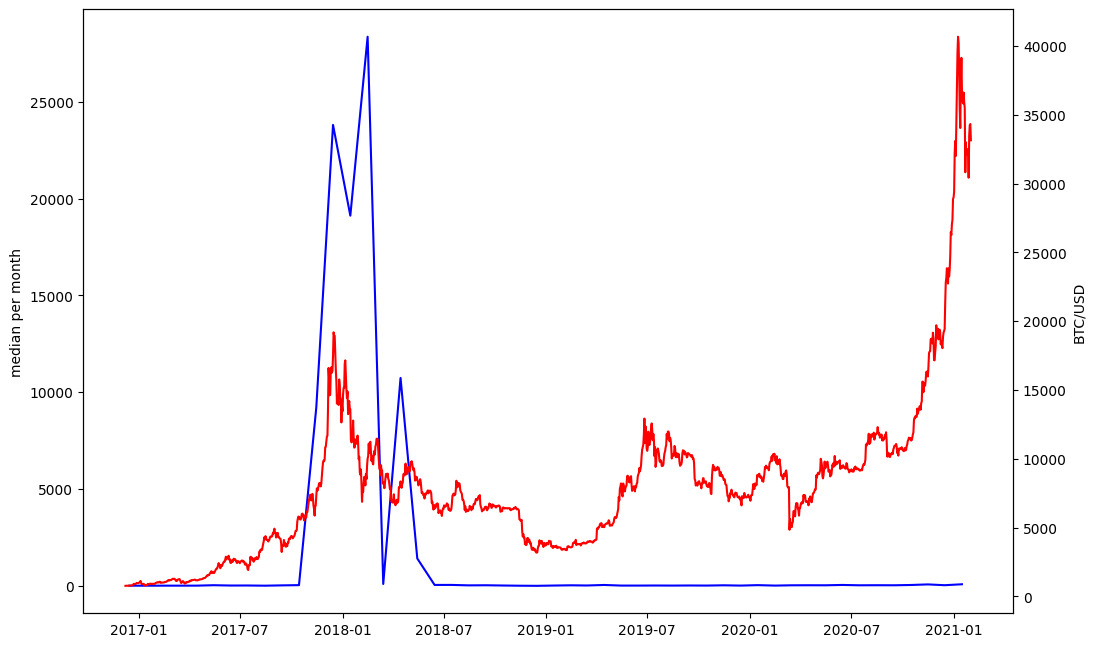

In [282]:
# transfers per month against bitcoin price
median = transactions_df.groupby('month').usd.agg(['median'])
fig, ax = plt.subplots()
ax.plot(median, c= 'b')
ax.set_ylabel('median per month')

ax2 = ax.twinx()
ax2.plot(day_prices_df, c= 'r')
ax2.set_ylabel('BTC/USD')

plt.savefig('median_vs_btc_usd.png',bbox_inches='tight')
plt.show()

In [283]:
transactions_df[transactions_df['back_usd']>0].sort_values(by='back_usd', ascending=False)

,hour,weekday,day,month,btc,usd,mixer,fee,back,back_addr,fee_usd,back_usd
541,17,2.708333,2020-07-29,2020-07-15,0.008302,92.249267,False,NaN,367.971791,33u48gM2gdz9TU5QT95JhvEpBB7zTHWPy2,NaN,4.088597e+06
193,8,3.333333,2021-01-14,2021-01-15,0.020000,782.687000,False,NaN,78.979767,352L2CChsnPLiZF2fbhNJ3exqhSbhggMzr,NaN,3.090822e+06
1845,8,5.333333,2018-08-25,2018-08-15,3.799600,25580.427040,False,NaN,233.140708,1Kr6QSydW9bFQG1mXiPNNu6WpJGmUa9i1g,NaN,1.569597e+06
2211,4,5.166667,2017-08-26,2017-08-15,0.005093,22.069038,False,NaN,151.574280,1KiLu81hB8moCDrmmFD2Eycnk4xQihenJ8,NaN,6.568290e+05
2001,13,3.541667,2017-10-05,2017-10-15,0.019245,82.776327,False,NaN,138.765609,18qEMgA6XnaDwqzbmeB4XFMH4N2sbRsNzU,NaN,5.968434e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
3573,22,1.916667,2016-12-13,2016-12-15,0.020000,15.574200,False,0.000500,0.000500,18qWzNTjgMuKuKMRMazAfuQX5ojGV53Xcr,0.389355,3.893550e-01
3390,19,1.791667,2017-01-24,2017-01-15,0.000110,0.098007,False,NaN,0.000413,1CijwseCR9mnX7aZm4vzQNm1UsTGrum4cE,NaN,3.686125e-01
3127,20,6.833333,2017-03-26,2017-03-15,0.010000,9.600000,False,0.000200,0.000200,1DHFHQ5cxvYtPvhZ5AHX2eN5e9eUfV3Eac,0.192000,1.920000e-01
3548,11,2.458333,2016-12-14,2016-12-15,0.060000,46.577400,False,0.000055,0.000055,12tPwtNxF4shegfE6aHLEe9j3zJJ2y7z1f,0.042696,4.269595e-02


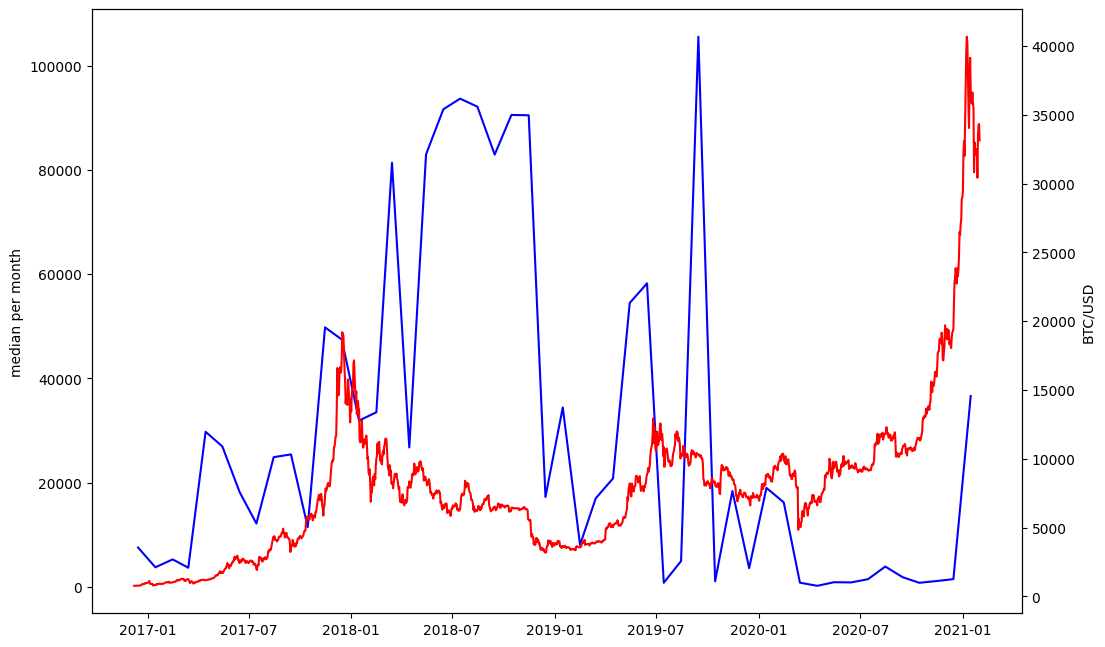

In [284]:
# max per month against bitcoin price
median = transactions_df.groupby('month').usd.agg(['max'])
fig, ax = plt.subplots()
ax.plot(median, c= 'b')
ax.set_ylabel('median per month')

ax2 = ax.twinx()
ax2.plot(day_prices_df, c= 'r')
ax2.set_ylabel('BTC/USD')

plt.show()

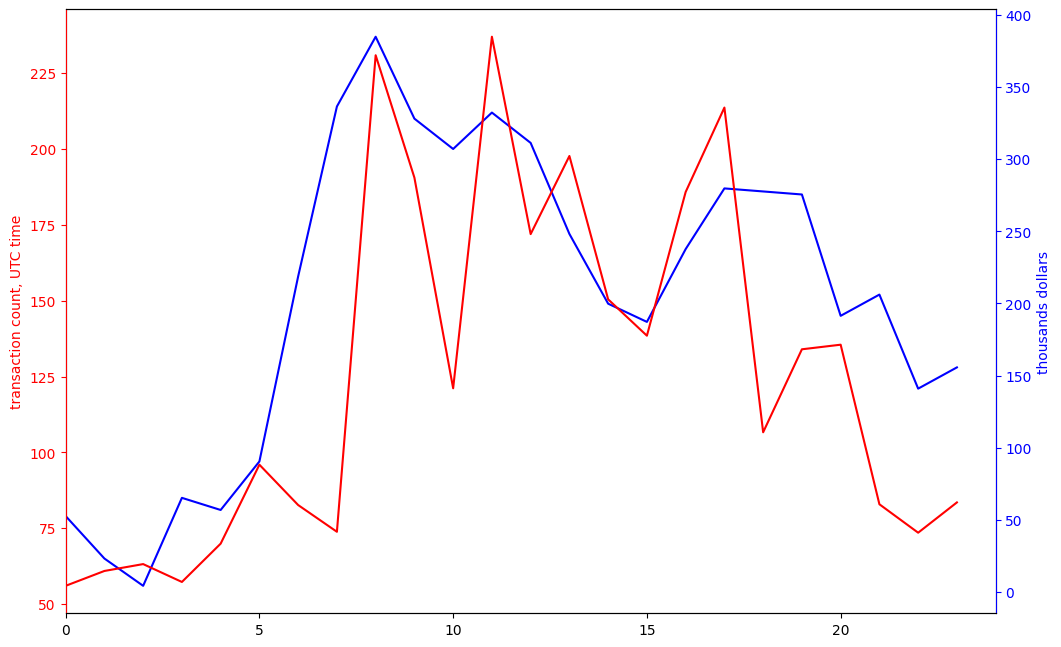

In [285]:
# dayhour usd/count

df = transactions_df
#df = transactions_df[transactions_df.usd > transactions_df.usd.quantile(.90)]

day_hour_count = df.groupby('hour').usd.agg(['count'])
day_hour_sum = df.groupby('hour').usd.agg(['sum'])
fig, ax = plt.subplots()
ax.plot(day_hour_count, c= 'b')
ax.set_ylabel('transaction count, UTC time')
ax.set_xlim([0,24])

ax2 = ax.twinx()
ax2.get_yaxis().set_major_formatter(
    plt_ticker.FuncFormatter(lambda x, p: format(int(x/1000), ','))
)
ax2.plot(day_hour_sum, c= 'r')
ax2.set_ylabel('thousands dollars')

ax.tick_params(axis='y', colors='red')
ax.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('b')

plt.savefig('usd_and_transaction_count_hour.png',bbox_inches='tight')

plt.show()

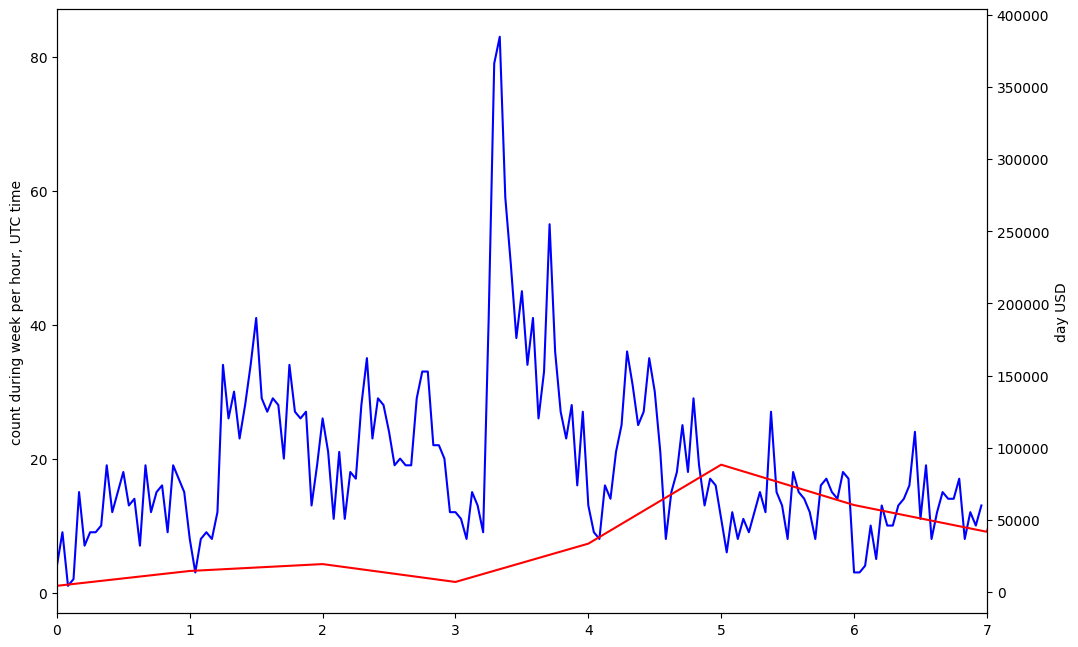

In [286]:
# same for weekdays
df = transactions_df[transactions_df.usd < transactions_df.usd.quantile(.90)]
week_hour_count = df.groupby('weekday').usd.agg(['count'])
week_hour_sum = df.groupby('weekday').usd.agg(['sum'])
fig, ax = plt.subplots()
ax.plot(week_hour_count, c= 'b')
ax.set_ylabel('count during week per hour, UTC time')
ax.set_xlim([0,7])

ax2 = ax.twinx()
ax2.plot(day_hour_sum, c= 'r')
ax2.set_ylabel('day USD')

plt.show()

In [287]:
transactions_df.groupby('weekday').usd.agg(['sum'])

,sum
weekday,
0.000000,131.308292
0.041667,306.503518
0.083333,199.587088
0.125000,1020.417642
0.166667,434.871698
...,...
6.791667,3633.845986
6.833333,24937.381532
6.875000,21191.909492


In [288]:
transactions_df.sort_values(by='usd')

,hour,weekday,day,month,btc,usd,mixer,fee,back,back_addr,fee_usd,back_usd
3499,16,3.666667,2016-12-15,2016-12-15,0.000006,0.004649,False,NaN,0.000761,1Fo4XTTSWaZBUxXKuMLdBNppcAP6TpNfYF,NaN,0.589406
3244,7,2.291667,2017-02-22,2017-02-15,0.000010,0.011300,False,NaN,0.000012,1JEyhU6qHopaUHRC2eknqgUc269pRvKUGD,NaN,0.013673
2858,0,6.000000,2017-05-28,2017-05-15,0.000007,0.015404,False,NaN,0.003255,1M9yzGYKFbyCPgF2gm1MbjL2XJYkSc16tB,NaN,7.092702
2710,3,3.125000,2017-06-15,2017-06-15,0.000008,0.020296,False,NaN,0.002109,1LKBTZBfBkEHsztiepNpvajAeTCze2iv5s,NaN,5.114499
2693,4,0.166667,2017-06-19,2017-06-15,0.000010,0.025980,False,NaN,0.000784,1FeYPCd2DPyQLrx3AAKwA8249dFcrKyX4P,NaN,2.035663
...,...,...,...,...,...,...,...,...,...,...,...,...
1797,11,6.458333,2018-10-14,2018-10-15,14.648248,90570.117755,True,NaN,NaN,None,NaN,NaN
1881,11,1.458333,2018-06-19,2018-06-15,13.606296,91659.081829,True,NaN,NaN,None,NaN,NaN
1850,17,1.708333,2018-08-14,2018-08-15,14.879840,92160.074373,True,NaN,NaN,None,NaN,NaN
1864,15,6.625000,2018-07-15,2018-07-15,14.756895,93695.956027,True,NaN,NaN,None,NaN,NaN


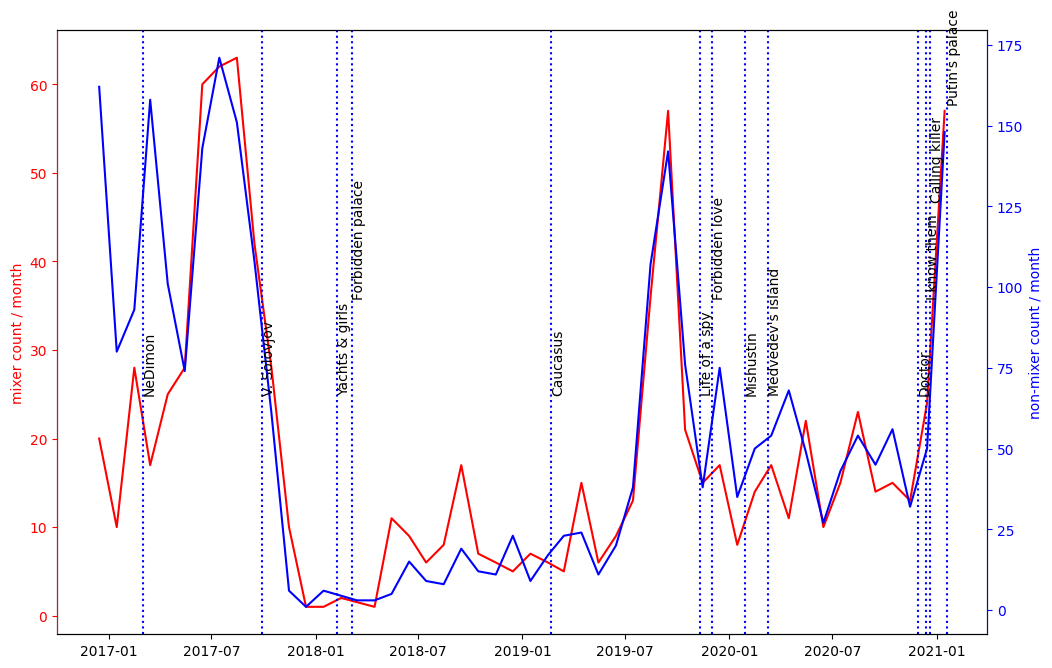

In [289]:
# mixer/non-mixer transaction counts
df1 = transactions_df[transactions_df['mixer'] == True].groupby('month').usd.agg(['count'])
 
fig, ax = plt.subplots()
plt.plot(df1, c= 'r')
plt.ylabel('mixer count / month')

df2 = transactions_df[transactions_df['mixer'] == False].groupby('month').usd.agg(['count'])
ax2 = ax.twinx()
ax2.plot(df2, c = 'b')
ax2.set_ylabel('non-mixer count / month')

ax.tick_params(axis='y', colors='red')
ax.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('b')

mark_dates(plt)

plt.savefig('mixer_count.png',bbox_inches='tight')

plt.show()

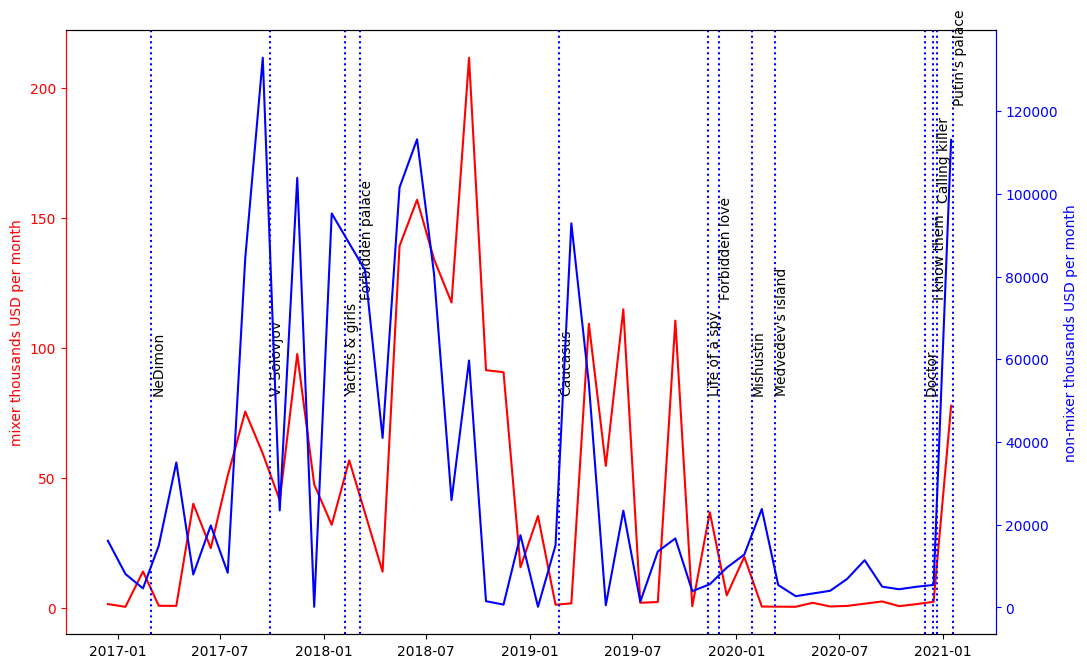

In [290]:
# mixer transactions totals per month
df1 = transactions_df[transactions_df['mixer'] == True].groupby('month').usd.agg(['sum'])
 
fig, ax = plt.subplots()
plt.plot(df1, c= 'r')
mark_dates(plt)
ax.get_yaxis().set_major_formatter(
    plt_ticker.FuncFormatter(lambda x, p: format(int(x/1000), ','))
)
plt.ylabel('mixer thousands USD per month')

df2 = transactions_df[transactions_df['mixer'] == False].groupby('month').usd.agg(['sum'])
ax2 = ax.twinx()
ax2.plot(df2, c= 'b')
ax2.set_ylabel('non-mixer thousands USD per month')

ax.tick_params(axis='y', colors='red')
ax.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('b')

plt.savefig('mixer_usd.png',bbox_inches='tight')

plt.show()

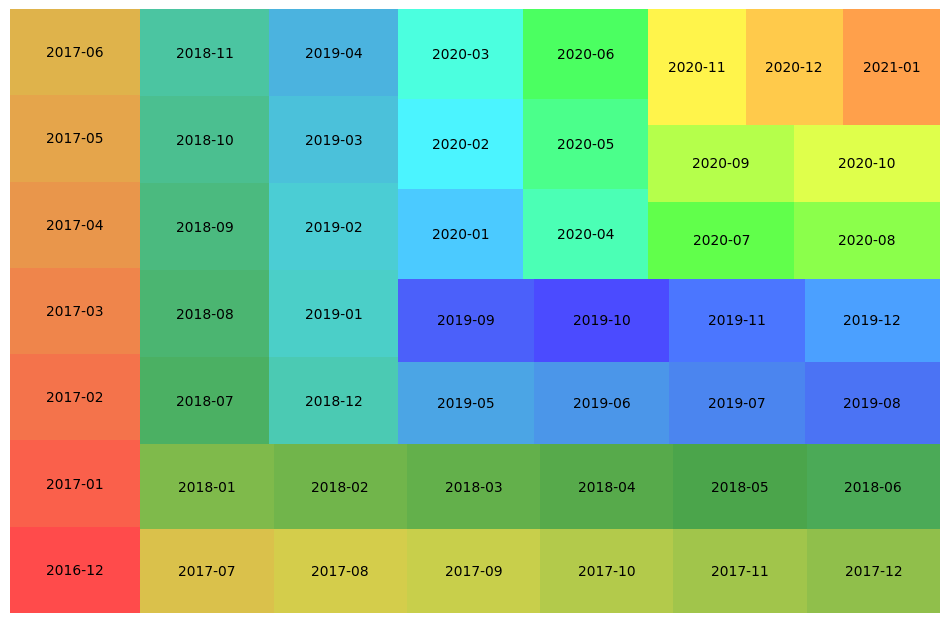

In [291]:
red = Color("red")
green = Color("green")
blue = Color("blue")

months = ['2016-12'] + [f'{year}-{month:02}' for year in range(2017, 2021) for month in range(1,12+1)] + ['2021-01']
# len(months) == 48 = 16*3
C = 18
T = 17
colors = list(red.range_to(green,C))[:T] + list(green.range_to(blue,C))[:T] + list(blue.range_to(red,C))[:T]
colors = [c.get_hex() for c in colors]
m2c = {m:c for m,c in zip(months, colors)}

def month_to_color(month):
    return m2c[month]

plt.rc('font', size=10)
squarify.plot(sizes=[10 for i in range(len(months))], label=months, color=colors, alpha=0.7)
plt.axis('off')

plt.show()

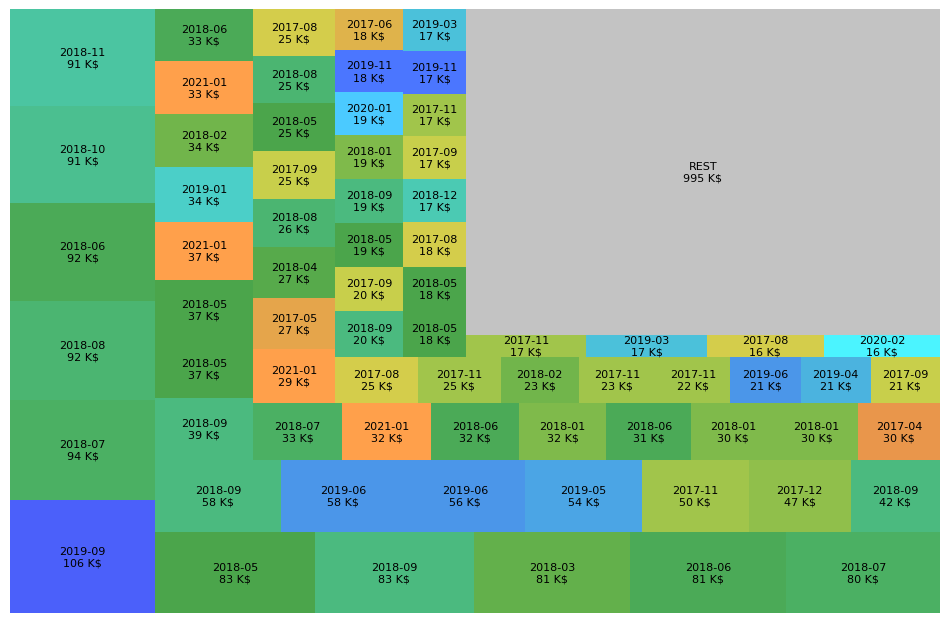

In [292]:
def get_year_month(dt):
    return '-'.join(str(dt).split('-')[:2])

N = 70
top_usd = [usd for usd in transactions_df.sort_values(by='usd', ascending=False).usd][:N]
top_month = [get_year_month(month) for month in transactions_df.sort_values(by='usd', ascending=False).month][:N]
color_list = [month_to_color(month) for month in top_month][:N] + ['#aaaaaa']
top_usd += [sum(transactions_df.usd) - sum(top_usd)]
top_month += ['REST']

plt.rc('font', size=8)
squarify.plot(sizes=top_usd, label=[f'{m}\n{round(d/1000)} K$' for m, d in zip(top_month,top_usd)], color=color_list, alpha=0.7)
plt.axis('off')

plt.savefig('usd_treemap.png',bbox_inches='tight')

plt.show()